# PneumoCNN #4
###Usando redes neurais convolucionais para auxiliar diagnóstico da Pneumonia


### Importando as bibliotecas necessárias


In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, MaxPool2D , Flatten , Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Dataset
A base de dados está organizada em 3 pastas(train, test, val) e contém subpastas para cada categoria de imagem (Pneumonia/Normal). 
5.863 X-Ray imagens (JPEG) e 2 categorias (Pneumonia/Normal).
Alguns desses arquivos indicam o tipo de pneumonia (viral, bacteria). Vamos usar essa informação para rearranjar a base de dados.

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        diag= ""
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                if "bacteria" in img:
                    diag = [1,0,0] 
                elif "virus" in img:
                    diag = [0,1,0] 
                else:
                    diag = [0,0,1]              
                data.append([resized_arr, class_num, diag])
            except Exception as e:
                print(img, e)
            print(img)
    return np.array(data)

# Carregando o Dataset

In [ ]:
train = get_training_data('drive/MyDrive/chest_xray/chest_xray/train')
val = get_training_data('drive/MyDrive/chest_xray/chest_xray/val')
test = get_training_data('drive/MyDrive/chest_xray/chest_xray/test')

IM-0061-0001.jpeg
IM-0093-0001.jpeg
NORMAL2-IM-0033-0001.jpeg
NORMAL2-IM-0041-0001.jpeg
NORMAL2-IM-0098-0001.jpeg
NORMAL2-IM-0150-0001.jpeg
IM-0099-0001.jpeg
IM-0097-0001.jpeg
IM-0101-0001.jpeg
IM-0103-0001.jpeg
IM-0111-0001.jpeg
IM-0070-0001.jpeg
NORMAL2-IM-0206-0001.jpeg
NORMAL2-IM-0045-0001.jpeg
NORMAL2-IM-0066-0001.jpeg
NORMAL2-IM-0060-0001.jpeg
IM-0043-0001.jpeg
NORMAL2-IM-0112-0001.jpeg
NORMAL2-IM-0111-0001.jpeg
IM-0069-0001.jpeg
NORMAL2-IM-0201-0001.jpeg
NORMAL2-IM-0092-0001.jpeg
NORMAL2-IM-0340-0001.jpeg
NORMAL2-IM-0277-0001.jpeg
NORMAL2-IM-0329-0001.jpeg
NORMAL2-IM-0373-0001.jpeg
NORMAL2-IM-0301-0001.jpeg
NORMAL2-IM-0252-0001.jpeg
NORMAL2-IM-0274-0001.jpeg
NORMAL2-IM-0361-0001.jpeg
NORMAL2-IM-0337-0001.jpeg
NORMAL2-IM-0366-0001.jpeg
NORMAL2-IM-0378-0001.jpeg
NORMAL2-IM-0251-0001.jpeg
NORMAL2-IM-0285-0001.jpeg
NORMAL2-IM-0246-0001-0001.jpeg
NORMAL2-IM-0381-0001.jpeg
NORMAL2-IM-0360-0001.jpeg
NORMAL2-IM-0364-0001.jpeg
NORMAL2-IM-0380-0001.jpeg
NORMAL2-IM-0369-0001.jpeg
NORMAL2-I

# Rearranjo do dataset
Precisamos redistruir o dataset para não ficar desbalanceado e conter amostras dos 3 casos no treino, validação e teste do modelo.

In [ ]:
x_data = []
y_data = []

for feature, label, diag in train:
    x_data.append(feature)
    y_data.append(diag)

for feature, label, diag in test:
    x_data.append(feature)
    y_data.append(diag)
    
for feature, label, diag in val:
    x_data.append(feature)
    y_data.append(diag)

y_class_num = [np.where(np.asarray(r)==1)[0][0] for r in y_data]


In [ ]:


samples = pd.DataFrame(y_class_num, columns = ['class_num'])
samples['diag'] = y_data
samples['img'] = x_data

smallest_diag_count = samples['class_num'].value_counts().min()

class0 = samples[samples['class_num'] == 0].sample(smallest_diag_count)
class1 = samples[samples['class_num'] == 1].sample(smallest_diag_count)
class2 = samples[samples['class_num'] == 2].sample(smallest_diag_count)

samples_under = pd.concat([class0, class1, class2], axis=0)

x = samples_under['img'].tolist()
y = samples_under['diag'].tolist()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

Normalização


In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
Para evitar problema de sobre ajuste, precisamos de aumentar artificialmente o dataset. Para isso iremos fazer o processo de data augmentation, que consiste em alterar as amostras de treino com transformações suaves(zoom, orientação, crops) para reproduzir as variações


In [ ]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,
        zca_whitening=False,  
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip = False,  
        vertical_flip=False)  
train_datagen.fit(x_train)

valid_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size = 32)

validation_generator = valid_datagen.flow(
    x_val,
    y_val)

test_generator = test_datagen.flow(
    x_test,
    y_test)


# Treinando o Modelo


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = Sequential()

#1Camada Convolucional
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(AvgPool2D((2,2) , strides = 2 , padding = 'same'))


#2Camada Convolucional
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


#3Camada Convolucional
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


#4Camada Convolucional
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


#5Camada Convolucional
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

#Camada Flatten
model.add(Flatten())

#Fully Connected
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(units = 3 , activation = 'softmax'))

#Compilação
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

#Resumo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 128)      

In [ ]:
class_weight = {0: 3, 1: 3, 2: 1}
loops = 20
history = []
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='auto')

for x in range(loops):
    history.append(model.fit(
            train_generator,
            steps_per_epoch=97,
            epochs=1,
            validation_data=test_generator,
            validation_steps=100,
            class_weight=class_weight,
            callbacks=[checkpoint]))

97/97 [==============================] - 138s 1s/step - loss: 2.3620 - accuracy: 0.3625 - val_loss: 1.2021 - val_accuracy: 0.4532

Epoch 00001: loss improved from inf to 2.28662, saving model to best_model.hdf5
97/97 [==============================] - 135s 1s/step - loss: 2.1191 - accuracy: 0.4751 - val_loss: 1.1236 - val_accuracy: 0.4695

Epoch 00001: loss improved from 2.28662 to 2.11914, saving model to best_model.hdf5
97/97 [==============================] - 136s 1s/step - loss: 2.1080 - accuracy: 0.5005 - val_loss: 1.0151 - val_accuracy: 0.5156

Epoch 00001: loss improved from 2.11914 to 2.10803, saving model to best_model.hdf5
97/97 [==============================] - 136s 1s/step - loss: 2.0428 - accuracy: 0.5233 - val_loss: 1.0364 - val_accuracy: 0.5349

Epoch 00001: loss improved from 2.10803 to 2.04280, saving model to best_model.hdf5
97/97 [==============================] - 134s 1s/step - loss: 2.0139 - accuracy: 0.5425 - val_loss: 0.9273 - val_accuracy: 0.5736

Epoch 00001: 

In [ ]:
print("Acurácia: " , model.evaluate(x_test,y_test)[1]*100 , "%")

22/22 [==============================] - 8s 351ms/step - loss: 0.4905 - accuracy: 0.7816
Acurácia:  78.15750241279602 %


# Resultado

In [ ]:
predictions = model.predict_classes(x_test)
y_test_num = [np.where(r==1)[0][0] for r in y_test]
names = ['Pneumonia Bacteria', 'Pneumonia Virus','Normal']


print(classification_report(y_test_num, predictions, target_names = names))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                    precision    recall  f1-score   support

Pneumonia Bacteria       0.80      0.60      0.69       220
   Pneumonia Virus       0.64      0.80      0.71       219
            Normal       0.94      0.93      0.94       234

          accuracy                           0.78       673
         macro avg       0.79      0.78      0.78       673
      weighted avg       0.80      0.78      0.78       673



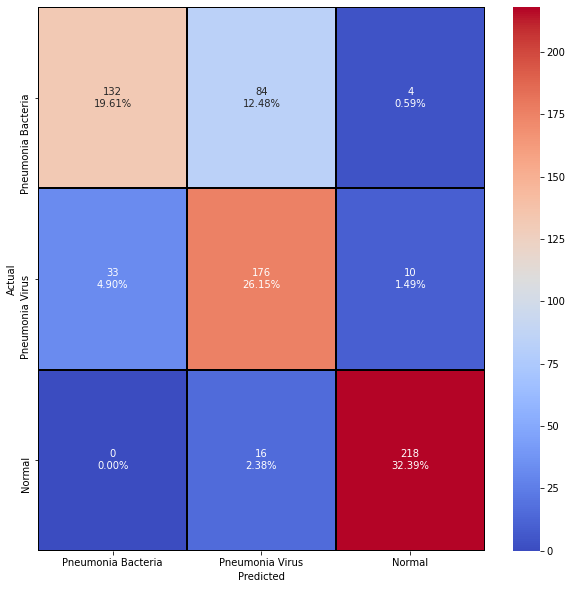

In [ ]:
cm = confusion_matrix(y_test_num,predictions)
cm = pd.DataFrame(cm , index = names , columns = names)
cm.index.name = 'Real'
cm.columns.name = 'Previsto'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            annot=labels,
            cmap= "coolwarm",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

Pela matriz de confusão podemos concluir que nosso modelo se mostra seguro na identificação de casos "NORMAL", mas erra muito na classificação das pneumonias.
Isso não é um problema tão grave quanto a ter muitos casos preditos positivos para NORMAL quando na verdade são casos de pneumonia.

In [ ]:
model.save('CNN.h5')